## TESTE de autograd com Polinomio de Legender para aproximação de Sen(x)

In [1]:
import torch
import math


class LegendrePolynomial3(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    
    @staticmethod
    def forward(ctx, input, params):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        ctx.custom_params = params
        k, l, m = params
        return k * (l * input ** 3 - m * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        k, l, m = ctx.custom_params

        grad_input = grad_output * k * (l * 3 * input ** 2 - m)
        grad_k = grad_output * (l * input ** 3 - m * input)
        grad_l = grad_output * k * input ** 3
        grad_m = grad_output * -k * input
        
        grad_params = (grad_k.sum(), grad_l.sum(), grad_m.sum())

        return grad_input, None


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0")  # Uncomment this to run on GPU

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Create random Tensors for weights. For this example, we need
# 4 weights: y = a + b * P3(c + d * x), these weights need to be initialized
# not too far from the correct result to ensure convergence.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

learning_rate = 5e-6
for t in range(2000):
    # To apply our Function, we use Function.apply method. We alias this as 'P3'.
    P3 = LegendrePolynomial3.apply
    params = (0.5,5,3)
    # Forward pass: compute predicted y using operations; we compute
    # P3 using our custom autograd operation.
    y_pred = a + b * P3(c + d * x, params)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')


99 209.95834350585938
199 144.66018676757812
299 100.70249938964844
399 71.03519439697266
499 50.97850799560547
599 37.403133392333984
699 28.206867218017578
799 21.97318458557129
899 17.7457275390625
999 14.877889633178711
1099 12.93176555633545
1199 11.610918998718262
1299 10.71425724029541
1399 10.10548210144043
1499 9.692106246948242
1599 9.411375045776367
1699 9.220745086669922
1799 9.091285705566406
1899 9.003360748291016
1999 8.943639755249023
Result: y = -5.446163964251127e-09 + -2.208526849746704 * P3(1.384728443021288e-09 + 0.2554861009120941 x)


## Outro teste que não lembro o que faz ou o pq que fiz outro, mas esse teste não "aprende"

In [2]:
import torch

class DeformPointsFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, points, control_points, control_points_delta, l, m, n):
        """
        Deforma os pontos da malha usando a grade de controle deformada.
        """
        updated_control_points = control_points + control_points_delta
        deformed_points = torch.zeros_like(points)
        
        # Salva variáveis para o backward
        ctx.save_for_backward(points, control_points, control_points_delta)
        ctx.l, ctx.m, ctx.n = l, m, n

        for p_idx, p in enumerate(points):
            u, v, w = p  # Assumimos que os pontos estão normalizados no intervalo [0,1]
            new_point = torch.zeros(3, dtype=points.dtype, device=points.device)

            for i in range(l):
                for j in range(m):
                    for k in range(n):
                        B_i = DeformPointsFunction.bernstein(i, l - 1, u)
                        B_j = DeformPointsFunction.bernstein(j, m - 1, v)
                        B_k = DeformPointsFunction.bernstein(k, n - 1, w)

                        new_point += B_i * B_j * B_k * updated_control_points[i, j, k]
            
            deformed_points[p_idx] = new_point
        
        return deformed_points

    @staticmethod
    def bernstein(i, n, u):
        """Calcula o polinômio de Bernstein."""
        from math import comb
        return torch.tensor(comb(n, i), dtype=u.dtype, device=u.device) * (u ** i) * ((1 - u) ** (n - i))

    @staticmethod
    def backward(ctx, grad_output):
        points, control_points, control_points_delta = ctx.saved_tensors
        l, m, n = ctx.l, ctx.m, ctx.n
        
        grad_points = torch.zeros_like(points)
        grad_control_points_delta = torch.zeros_like(control_points_delta)
        
        for p_idx, p in enumerate(points):
            u, v, w = p
            grad = grad_output[p_idx]
            
            for i in range(l):
                for j in range(m):
                    for k in range(n):
                        B_i = DeformPointsFunction.bernstein(i, l - 1, u)
                        B_j = DeformPointsFunction.bernstein(j, m - 1, v)
                        B_k = DeformPointsFunction.bernstein(k, n - 1, w)
                        grad_control_points_delta[i, j, k] += B_i * B_j * B_k * grad

        return grad_points, None, grad_control_points_delta, None, None, None


class DeformLayer:
    def __init__(self, control_points, l, m, n):
        self.control_points = control_points
        self.l, self.m, self.n = l, m, n

    def __call__(self, points, control_points_delta):
        return DeformPointsFunction.apply(points, self.control_points, control_points_delta, self.l, self.m, self.n)


class ControlMeshAdjuster:
    def __init__(self, initial_mesh, target_mesh, control_points, l, m, n, learning_rate=0.01):
        """
        Classe que ajusta a malha de controle para deformar a malha inicial em direção à malha alvo.
        """
        self.initial_mesh = initial_mesh
        self.target_mesh = target_mesh
        self.control_points = control_points.clone().detach()
        self.control_points_delta = torch.zeros((l, m, n, 3), requires_grad=True)
        self.l, self.m, self.n = l, m, n
        self.layer = DeformLayer(control_points=self.control_points, l=l, m=m, n=n)
        self.optimizer = torch.optim.SGD([self.control_points_delta], lr=learning_rate)

    def step(self):
        """
        Executa uma iteração de ajuste da malha de controle usando backpropagation.
        """
        self.optimizer.zero_grad()
        
        # Deforma a malha inicial usando os pontos de controle e deltas
        deformed_mesh = self.layer(self.initial_mesh, self.control_points_delta)
        
        # Calcula a função de perda entre a malha deformada e a malha alvo
        loss = self.calculate_loss(deformed_mesh, self.target_mesh)
        
        # Realiza backpropagation para calcular os gradientes
        loss.backward()
        
        # Atualiza os deltas da malha de controle
        self.optimizer.step()
        
        return loss.item()

    def calculate_loss(self, deformed_mesh, target_mesh):
        """
        Função de perda que compara a malha deformada com a malha alvo.
        """
        # Aqui vamos assumir que a função de perda já está implementada e funcional
        # Por exemplo, pode ser algo como torch.nn.functional.mse_loss(deformed_mesh, target_mesh)
        return torch.nn.functional.mse_loss(deformed_mesh, target_mesh)

    def train(self, epochs):
        """
        Treina a malha de controle para ajustar a malha inicial em direção à malha alvo.
        """
        for epoch in range(epochs):
            loss = self.step()
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.6f}")

In [3]:
# Exemplo de entrada para a malha inicial e alvo (ambas com formato (N, 3))
initial_mesh = torch.rand((5, 3), requires_grad=True)  # Pontos da malha inicial
target_mesh = torch.rand((5, 3), requires_grad=False)  # Pontos da malha alvo

# Definimos os pontos de controle (exemplo: 2x2x2 grid de controle)
control_points = torch.rand((2, 2, 2, 3))

# Inicializamos o ajustador de malha com a malha inicial, alvo e pontos de controle
adjuster = ControlMeshAdjuster(
    initial_mesh=initial_mesh,
    target_mesh=target_mesh,
    control_points=control_points,
    l=2, m=2, n=2,
    learning_rate=0.01
)

# Treinamos a malha de controle por um número de épocas
adjuster.train(epochs=100)

Epoch 1/100, Loss: 0.067008
Epoch 2/100, Loss: 0.066936
Epoch 3/100, Loss: 0.066864
Epoch 4/100, Loss: 0.066793
Epoch 5/100, Loss: 0.066721
Epoch 6/100, Loss: 0.066650
Epoch 7/100, Loss: 0.066579
Epoch 8/100, Loss: 0.066508
Epoch 9/100, Loss: 0.066437
Epoch 10/100, Loss: 0.066366
Epoch 11/100, Loss: 0.066295
Epoch 12/100, Loss: 0.066225
Epoch 13/100, Loss: 0.066155
Epoch 14/100, Loss: 0.066085
Epoch 15/100, Loss: 0.066015
Epoch 16/100, Loss: 0.065945
Epoch 17/100, Loss: 0.065875
Epoch 18/100, Loss: 0.065806
Epoch 19/100, Loss: 0.065736
Epoch 20/100, Loss: 0.065667
Epoch 21/100, Loss: 0.065598
Epoch 22/100, Loss: 0.065529
Epoch 23/100, Loss: 0.065460
Epoch 24/100, Loss: 0.065391
Epoch 25/100, Loss: 0.065323
Epoch 26/100, Loss: 0.065255
Epoch 27/100, Loss: 0.065186
Epoch 28/100, Loss: 0.065118
Epoch 29/100, Loss: 0.065050
Epoch 30/100, Loss: 0.064983
Epoch 31/100, Loss: 0.064915
Epoch 32/100, Loss: 0.064848
Epoch 33/100, Loss: 0.064780
Epoch 34/100, Loss: 0.064713
Epoch 35/100, Loss: 0.0

## Esse teste tem funcionado e deforma corretamente a malha

In [23]:
import torch
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj
import numpy as np
import warnings

class FreeFormDeformation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, verts, control_points, control_points_delta, l, m, n):
        """
        Aplica deformação FFD a uma malha.
        
        Args:
            verts: Vértices da malha (N, 3).
            control_points: Pontos de controle da malha FFD (l, m, n, 3).
            control_points_delta: Deltas a serem aplicados nos pontos de controle (l, m, n, 3).
            l, m, n: Dimensões da grade de controle FFD.

        Returns:
            verts_deformed: Vértices da malha após a deformação FFD.
        """
        updated_control_points = control_points + control_points_delta
        deformed_verts = torch.zeros_like(verts)

        # Armazena para o backward
        ctx.save_for_backward(verts, control_points, control_points_delta)
        ctx.l, ctx.m, ctx.n = l, m, n

        # Itera sobre os vértices da malha
        for v_idx, v in enumerate(verts):
            u, v, w = v  # Assumindo os vértices normalizados no intervalo [0, 1]
            new_vert = torch.zeros(3, dtype=verts.dtype, device=verts.device)

            for i in range(l):
                for j in range(m):
                    for k in range(n):
                        B_i = FreeFormDeformation.bernstein(i, l - 1, u)
                        B_j = FreeFormDeformation.bernstein(j, m - 1, v)
                        B_k = FreeFormDeformation.bernstein(k, n - 1, w)
                        new_vert += B_i * B_j * B_k * updated_control_points[i*(l**2) + j*m + k]
            
            deformed_verts[v_idx] = new_vert
        
        return deformed_verts

    @staticmethod
    def bernstein(i, n, u):
        """Calcula o polinômio de Bernstein para FFD."""
        from math import comb
        return torch.tensor(comb(n, i), dtype=u.dtype, device=u.device) * (u ** i) * ((1 - u) ** (n - i))

    @staticmethod
    def bernstein_gradient(i, n, u):
        """Calcula o polinômio de Bernstein para FFD."""
        from math import comb
        return -u**(-1+i) * torch.tensor(comb(n, i), dtype=u.dtype, device=u.device) * (n*u-i) * ((1-u)**(n-1-i))
    
    @staticmethod
    def backward(ctx, grad_output):
        verts, control_points, control_points_delta = ctx.saved_tensors
        l, m, n = ctx.l, ctx.m, ctx.n

        grad_control_points_delta = torch.zeros_like(control_points_delta)

        for v_idx, v in enumerate(verts):
            u, v, w = v
            grad = grad_output[v_idx]

            for i in range(l):
                for j in range(m):
                    for k in range(n):
                        B_i = FreeFormDeformation.bernstein(i, l - 1, u)
                        B_j = FreeFormDeformation.bernstein(j, m - 1, v)
                        B_k = FreeFormDeformation.bernstein(k, n - 1, w)
                        grad_control_points_delta[i*(l**2) + j*m + k] += B_i * B_j * B_k * grad

        return None, None, grad_control_points_delta, None, None, None


class FFDLayer:
    def __init__(self, l, m, n, control_points=None, normalizer = None):
        """
        FFD Layer que aplica a deformação FFD nos vértices da malha.
        """
        self.dimension = (l, m, n)
        
        self.normalizer = normalizer if normalizer else None
        
        self.control_points = control_points if control_points is not None else torch.tensor(np.array([[[[i/(l-1), j/(m-1), k/(n-1)] for k in range(n)] for j in range(m)] for i in range(l)]).reshape(l*m*n,3))
        
        self.l, self.m, self.n = l, m, n

    
    def check_and_normalize(self, points):
        """
        Verifica se os pontos estão normalizados e aplica normalização, se necessário.
        
        Args:
            points: Tensor de pontos a serem verificados e possivelmente normalizados.
            
        Returns:
            points: Tensor de pontos normalizados, se necessário.
        """
        # Verifica se os pontos estão no intervalo [0, 1]
        if not (torch.all(points >= 0) and torch.all(points <= 1)):
            if self.normalizer:
                # Aplica normalizador personalizado
                points = self.normalizer([points])
                warnings.warn("Pontos de entrada foram normalizados usando o `normalizer` fornecido.")
            else:
                # Normaliza automaticamente
                min_vals = points.min(dim=0, keepdim=True)[0]
                max_vals = points.max(dim=0, keepdim=True)[0]
                points = (points - min_vals) / (max_vals - min_vals)
                points = points
                warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")
        
        return points

    def __call__(self, points, control_points_delta):
        """
        Aplica a deformação FFD nos pontos fornecidos após verificação e normalização.
        
        Args:
            points: Tensor de pontos a serem deformados.
            control_points_delta: Tensor de deltas para os pontos de controle.
            
        Returns:
            Tensor de pontos deformados.
        """
        # Verifica e normaliza os pontos, se necessário
        points = self.check_and_normalize(points)
        
        # Calcula e retorna os pontos deformados com o Free Form Deformation
        return FreeFormDeformation.apply(points, self.control_points, control_points_delta, self.l, self.m, self.n)




In [37]:

trg_obj = 'dolphin.obj'
verts, faces, aux = load_obj(trg_obj)
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

trg_mesh = Meshes(verts=[verts], faces=[faces_idx])
src_mesh = ico_sphere(4, device)

/usr/local/lib/python3.8/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [38]:
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
# Exemplo de uso com pytorch3d para carregar uma malha e aplicar FFD
# Carrega uma malha de exemplo (assumindo que você tem um arquivo de malha OBJ)
trg_obj = 'dolphin.obj'
trg_verts, trg_faces, _ = load_obj(trg_obj)
mesh = Meshes(verts=[trg_verts], faces=[trg_faces.verts_idx])

src_mesh = ico_sphere(4, device)
src_verts = src_mesh.verts_list()[0]

# Inicializa pontos de controle e deltas
l, m, n = 2, 2, 2
control_points = torch.tensor(np.array([[[[i/(l-1), j/(m-1), k/(n-1)] for k in range(n)] for j in range(m)] for i in range(l)]).reshape(l*m*n,3))
          # Posição inicial dos pontos de controle
# control_points = torch.rand((l, m, n, 3), requires_grad=False)  # Posição inicial dos pontos de controle
control_points_delta = torch.zeros((l*m*n, 3), requires_grad=True)  # Deltas ajustáveis para FFD

# Inicializa a camada FFD
ffd_layer = FFDLayer(l=l, m=m, n=n)

# Aplica deformação nos vértices da malha
deformed_verts = ffd_layer(src_verts, control_points_delta)

# Cria a malha deformada com os vértices deformados
deformed_mesh = Meshes(verts=[deformed_verts], faces=[faces.verts_idx])

trg_mesh = mesh
new_src_mesh_ffd = deformed_mesh

# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 


# We sample 5k points from the surface of each mesh 
sample_trg = sample_points_from_meshes(trg_mesh, 5000)
# sample_src = sample_points_from_meshes(new_src_mesh, 5000)
sample_src_ffd = sample_points_from_meshes(new_src_mesh_ffd, 5000)

# We compare the two sets of pointclouds by computing (a) the chamfer loss
# loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
loss_chamfer_ffd, _ = chamfer_distance(sample_trg, sample_src_ffd)

# and (b) the edge length of the predicted mesh
# loss_edge = mesh_edge_loss(new_src_mesh)
loss_edge_ffd = mesh_edge_loss(new_src_mesh_ffd)

# mesh normal consistency
# loss_normal = mesh_normal_consistency(new_src_mesh)
loss_normal_ffd = mesh_normal_consistency(new_src_mesh_ffd)

# mesh laplacian smoothing
# loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
loss_laplacian_ffd = mesh_laplacian_smoothing(new_src_mesh_ffd, method="uniform")

# Weighted sum of the losses
# loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
loss_ffd = loss_chamfer_ffd * w_chamfer + loss_edge_ffd * w_edge + loss_normal_ffd * w_normal + loss_laplacian_ffd * w_laplacian

# Print the losses
# print(f'iter{i}: total_loss = {loss:.6f}')
print(f'total_loss = {loss_ffd:.6f}')
loss_ffd.backward()
print(control_points_delta.grad)

/tmp/ipykernel_13535/168218363.py:119: UserWarning: Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].
  warnings.warn("Pontos de entrada foram automaticamente normalizados para o intervalo [0, 1].")


total_loss = 0.489519
tensor([[ 0.1804,  0.0461,  0.1440],
        [ 0.0988, -0.0035,  0.0997],
        [ 0.1400,  0.0868,  0.0839],
        [ 0.0936,  0.0634,  0.0871],
        [ 0.1648,  0.0161,  0.0598],
        [ 0.1546, -0.0033,  0.0956],
        [ 0.1605,  0.0750,  0.0381],
        [ 0.1593,  0.0644,  0.0867]])


In [39]:
new_src_mesh_ffd.verts_list()

[tensor([[0.2372, 0.9253, 0.5000],
         [0.7628, 0.9253, 0.5000],
         [0.2372, 0.0747, 0.5000],
         ...,
         [0.3329, 0.4794, 0.0292],
         [0.3329, 0.5206, 0.0292],
         [0.2995, 0.5000, 0.0420]], grad_fn=<FreeFormDeformationBackward>)]

In [44]:
from pytorch3d.loss import chamfer_distance, mesh_edge_loss, mesh_normal_consistency, mesh_laplacian_smoothing
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj
from pytorch3d.ops import sample_points_from_meshes
import torch

# Carrega a malha alvo
trg_obj = 'dolphin.obj'
trg_verts, trg_faces, _ = load_obj(trg_obj)
min_vals = trg_verts.min(dim=0, keepdim=True)[0]
max_vals = trg_verts.max(dim=0, keepdim=True)[0]
trg_verts = (trg_verts - min_vals) / (max_vals - min_vals)

trg_mesh = Meshes(verts=[trg_verts], faces=[trg_faces.verts_idx])

src_mesh = ico_sphere(4, device)
src_verts = src_mesh.get_mesh_verts_faces(0)[0]
min_vals = src_verts.min(dim=0, keepdim=True)[0]
max_vals = src_verts.max(dim=0, keepdim=True)[0]
src_verts = (src_verts - min_vals) / (max_vals - min_vals)


# Configura os parâmetros de FFD e a malha de controle
l, m, n = 2, 2, 2
# control_points = torch.rand((l, m, n, 3), requires_grad=False)  # Pontos de controle iniciais
control_points = torch.tensor(np.array([[[[i/(l-1), j/(m-1), k/(n-1)] for k in range(n)] for j in range(m)] for i in range(l)]).reshape(l*m*n,3))
control_points_delta = torch.zeros((l*m*n, 3), requires_grad=True)  # Deltas ajustáveis para FFD

# Configura a camada FFD
ffd_layer = FFDLayer(l=l, m=m, n=n)

# Configura o otimizador
learning_rate = 0.1
optimizer = torch.optim.SGD([control_points_delta], lr=learning_rate)

# Pesos das perdas
w_chamfer = 1.0 
w_edge = 1.0 
w_normal = 0.01 
w_laplacian = 0.1 

# Iterações de treinamento
num_iterations = 50
sample_trg = sample_points_from_meshes(trg_mesh, 5000)

for i in range(num_iterations):
    optimizer.zero_grad()  # Zera os gradientes do otimizador
    
    # Aplica FFD nos vértices da malha inicial
    deformed_verts = ffd_layer(src_verts, control_points_delta)
    
    # Cria a nova malha deformada
    new_src_mesh_ffd = Meshes(verts=[deformed_verts], faces=[faces.verts_idx])
    
    # Amostra pontos da superfície de ambas as malhas para cálculo da Chamfer Loss
    sample_src_ffd = sample_points_from_meshes(new_src_mesh_ffd, 5000)
    
    # Calcula as perdas
    loss_chamfer_ffd, _ = chamfer_distance(sample_trg, sample_src_ffd)
    loss_edge_ffd = mesh_edge_loss(new_src_mesh_ffd)
    loss_normal_ffd = mesh_normal_consistency(new_src_mesh_ffd)
    loss_laplacian_ffd = mesh_laplacian_smoothing(new_src_mesh_ffd, method="uniform")
    
    # Soma ponderada das perdas
    loss_ffd = (loss_chamfer_ffd * w_chamfer +
                loss_edge_ffd * w_edge +
                loss_normal_ffd * w_normal +
                loss_laplacian_ffd * w_laplacian)
    
    # Imprime a perda total para monitoramento
    print(f'Iteração {i + 1}/{num_iterations}, Loss: {loss_ffd.item():.6f}')
    
    # Backpropagation
    loss_ffd.backward()
    
    # Atualiza os deltas dos pontos de controle com o otimizador
    optimizer.step()
    
    # Verifica os gradientes (opcional para depuração)
    # if i % 100 == 0:  # Exibe a cada 100 iterações
    #     print("Gradientes dos deltas dos pontos de controle:")
    #     print(control_points_delta.grad)


Iteração 1/50, Loss: 0.485949
Iteração 2/50, Loss: 0.466641
Iteração 3/50, Loss: 0.438212
Iteração 4/50, Loss: 0.409971
Iteração 5/50, Loss: 0.396621
Iteração 6/50, Loss: 0.384491
Iteração 7/50, Loss: 0.362282
Iteração 8/50, Loss: 0.344825
Iteração 9/50, Loss: 0.335716
Iteração 10/50, Loss: 0.325804
Iteração 11/50, Loss: 0.305835
Iteração 12/50, Loss: 0.297894
Iteração 13/50, Loss: 0.291505
Iteração 14/50, Loss: 0.281740
Iteração 15/50, Loss: 0.274726
Iteração 16/50, Loss: 0.259534
Iteração 17/50, Loss: 0.255989
Iteração 18/50, Loss: 0.243666
Iteração 19/50, Loss: 0.234571
Iteração 20/50, Loss: 0.231057
Iteração 21/50, Loss: 0.223667
Iteração 22/50, Loss: 0.223825
Iteração 23/50, Loss: 0.206651
Iteração 24/50, Loss: 0.205992
Iteração 25/50, Loss: 0.196028
Iteração 26/50, Loss: 0.195719
Iteração 27/50, Loss: 0.188580
Iteração 28/50, Loss: 0.184212
Iteração 29/50, Loss: 0.177019
Iteração 30/50, Loss: 0.174719
Iteração 31/50, Loss: 0.169607
Iteração 32/50, Loss: 0.165968
Iteração 33/50, L

## Agora um teste utilizando multiplas camadas sequenciais de Free Form Deformation

In [29]:
import pickle

def save_training_data(filename, data):
    """
    Salva os dados do treinamento em um arquivo pickle.
    
    Args:
        filename (str): Nome do arquivo para salvar os dados.
        data (dict): Dicionário contendo os dados do treinamento.
    """
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Dados salvos em {filename}")

def load_training_data(filename):
    """
    Carrega os dados do treinamento de um arquivo pickle.
    
    Args:
        filename (str): Nome do arquivo para carregar os dados.
        
    Returns:
        dict: Dicionário contendo os dados do treinamento.
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Dados carregados de {filename}")
    return data


In [25]:
import matplotlib.pyplot as plt
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [30]:
import torch
from pytorch3d.loss import chamfer_distance, mesh_edge_loss, mesh_normal_consistency, mesh_laplacian_smoothing
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.utils import ico_sphere
import numpy as np

def train(
    src_mesh, trg_mesh,
    dimension = (3,3,3),
    learning_rate = 0.5,
    # Loss weights
    w_chamfer = 1.0,
    w_edge = 1.0,
    w_normal = 0.01,
    w_laplacian = 0.1,
    print_interval = 10,
    num_iterations = 100,
    num_layers = 3,
    **kwargs
):
    l, m, n = dimension
    error_hist = []
    control_points = torch.tensor(
        np.array([[[[i / (l - 1), j / (m - 1), k / (n - 1)] 
                    for k in range(n)] 
                    for j in range(m)] 
                    for i in range(l)]).reshape(l * m * n, 3),
        requires_grad=False,
        device=device
    )
    
    # Configure FFD layers
    control_points_deltas = [
        torch.zeros((l * m * n, 3), requires_grad=True, device=device) 
        for _ in range(num_layers)
    ]

    ffd_layers = [FFDLayer(l=l, m=m, n=n, control_points=control_points) for _ in range(num_layers)]
    
    # Configure optimizer
    optimizer = torch.optim.SGD(control_points_deltas, lr=learning_rate)
    
    # Training loop
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        # Apply FFD layers sequentially
        deformed_verts = src_verts.clone()
        for layer, delta in zip(ffd_layers, control_points_deltas):
            deformed_verts = layer(deformed_verts, delta)
        
        # Create the deformed mesh
        new_src_mesh_ffd = Meshes(verts=[deformed_verts], faces=[src_mesh.faces_packed()])
        
        # Sample points for Chamfer loss
        sample_src_ffd = sample_points_from_meshes(new_src_mesh_ffd, 5000)
        
        # Compute losses
        loss_chamfer_ffd, _ = chamfer_distance(sample_trg, sample_src_ffd)
        loss_edge_ffd = mesh_edge_loss(new_src_mesh_ffd)
        loss_normal_ffd = mesh_normal_consistency(new_src_mesh_ffd)
        loss_laplacian_ffd = mesh_laplacian_smoothing(new_src_mesh_ffd, method="uniform")
        
        # Total loss
        loss_ffd = (loss_chamfer_ffd * w_chamfer +
                    loss_edge_ffd * w_edge +
                    loss_normal_ffd * w_normal +
                    loss_laplacian_ffd * w_laplacian)

        error_hist.append([loss_chamfer_ffd, loss_edge_ffd, loss_normal_ffd, loss_laplacian_ffd])
        
        # Log loss
        print(f'Iteration {i + 1}/{num_iterations}, Loss: {loss_ffd.item():.6f}')
        if i % print_interval == 0:
            plot_pointcloud(new_src_mesh_ffd)
        
        # Backpropagation
        loss_ffd.backward()
        
        # Update control points deltas
        optimizer.step()

    return {'final_mesh' : new_src_mesh_ffd, 'delta_points' : control_points_deltas, 'error_hist' : error_hist}


Iteration 1/5, Loss: 0.099423


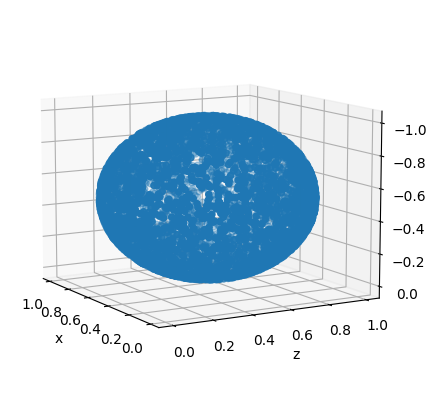

Iteration 2/5, Loss: 0.095086
Iteration 3/5, Loss: 0.093934


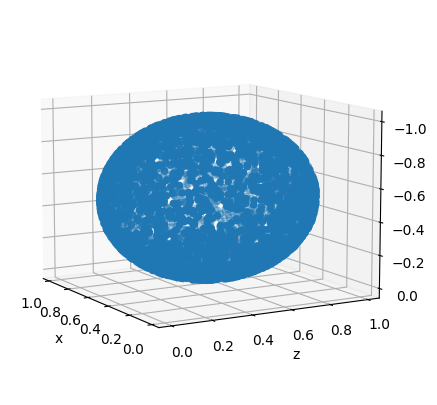

Iteration 4/5, Loss: 0.091375
Iteration 5/5, Loss: 0.090414


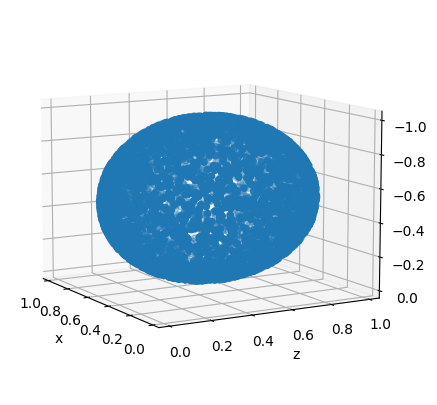

KeyError: 'deltas'

In [35]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")
    
# Load target mesh and normalize
trg_obj = 'dolphin.obj'
trg_verts, trg_faces, _ = load_obj(trg_obj)
min_vals = trg_verts.min(dim=0, keepdim=True)[0]
max_vals = trg_verts.max(dim=0, keepdim=True)[0]
trg_verts = (trg_verts - min_vals) / (max_vals - min_vals)
trg_mesh = Meshes(verts=[trg_verts], faces=[trg_faces.verts_idx])

# Load source mesh and normalize
src_mesh = ico_sphere(4, device=device)
src_verts = src_mesh.verts_packed()
min_vals = src_verts.min(dim=0, keepdim=True)[0]
max_vals = src_verts.max(dim=0, keepdim=True)[0]
src_verts = (src_verts - min_vals) / (max_vals - min_vals)

# Configure FFD control points

settings = {
    'num_layers' : 3,
    'dimension' : (3,3,3), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 0.1,
    'print_interval' : 2,
    'num_iterations' : 5
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./traino_1.pkl' , data)

In [39]:
data2 = load_training_data("./traino_1.pkl")

Dados carregados de ./traino_1.pkl


## Varios teste de performance

Iteration 1/100, Loss: 0.101918


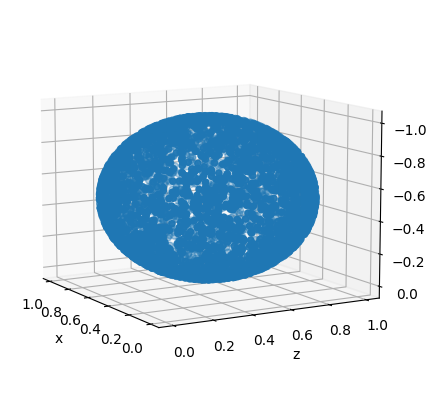

Iteration 2/100, Loss: 0.098099
Iteration 3/100, Loss: 0.093764
Iteration 4/100, Loss: 0.092904
Iteration 5/100, Loss: 0.089042
Iteration 6/100, Loss: 0.085815
Iteration 7/100, Loss: 0.082944
Iteration 8/100, Loss: 0.080214
Iteration 9/100, Loss: 0.078216
Iteration 10/100, Loss: 0.076509
Iteration 11/100, Loss: 0.073420
Iteration 12/100, Loss: 0.071592
Iteration 13/100, Loss: 0.069059
Iteration 14/100, Loss: 0.068886
Iteration 15/100, Loss: 0.065388
Iteration 16/100, Loss: 0.063764
Iteration 17/100, Loss: 0.060956
Iteration 18/100, Loss: 0.059625
Iteration 19/100, Loss: 0.057396
Iteration 20/100, Loss: 0.055817
Iteration 21/100, Loss: 0.054148
Iteration 22/100, Loss: 0.053035
Iteration 23/100, Loss: 0.051092
Iteration 24/100, Loss: 0.049056
Iteration 25/100, Loss: 0.047574
Iteration 26/100, Loss: 0.045926
Iteration 27/100, Loss: 0.044468
Iteration 28/100, Loss: 0.043077
Iteration 29/100, Loss: 0.041963
Iteration 30/100, Loss: 0.040103
Iteration 31/100, Loss: 0.038943
Iteration 32/100, 

In [40]:
settings = {
    'num_layers' : 3,
    'dimension' : (3,3,3), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 100
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_01.pkl' , data)

Iteration 1/100, Loss: 0.099874


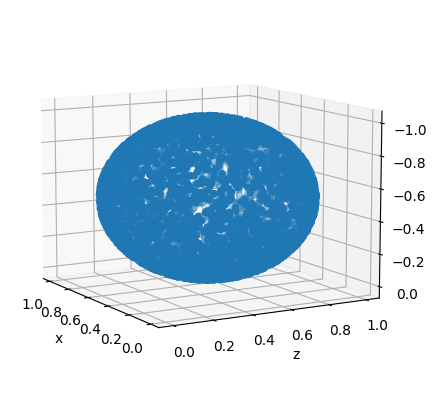

Iteration 2/100, Loss: 0.097712
Iteration 3/100, Loss: 0.094789
Iteration 4/100, Loss: 0.091778
Iteration 5/100, Loss: 0.087160
Iteration 6/100, Loss: 0.087129
Iteration 7/100, Loss: 0.082319
Iteration 8/100, Loss: 0.080144
Iteration 9/100, Loss: 0.077514
Iteration 10/100, Loss: 0.076053
Iteration 11/100, Loss: 0.073851
Iteration 12/100, Loss: 0.071429
Iteration 13/100, Loss: 0.068656
Iteration 14/100, Loss: 0.068855
Iteration 15/100, Loss: 0.065777
Iteration 16/100, Loss: 0.063526
Iteration 17/100, Loss: 0.061775
Iteration 18/100, Loss: 0.059908
Iteration 19/100, Loss: 0.057294
Iteration 20/100, Loss: 0.055293
Iteration 21/100, Loss: 0.054252
Iteration 22/100, Loss: 0.052356
Iteration 23/100, Loss: 0.050493
Iteration 24/100, Loss: 0.049160
Iteration 25/100, Loss: 0.047729
Iteration 26/100, Loss: 0.045851
Iteration 27/100, Loss: 0.044270
Iteration 28/100, Loss: 0.042169
Iteration 29/100, Loss: 0.042344
Iteration 30/100, Loss: 0.040455
Iteration 31/100, Loss: 0.038063
Iteration 32/100, 

In [41]:
settings = {
    'num_layers' : 1,
    'dimension' : (3,3,3), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 100
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_02.pkl' , data)

Iteration 1/500, Loss: 0.098938


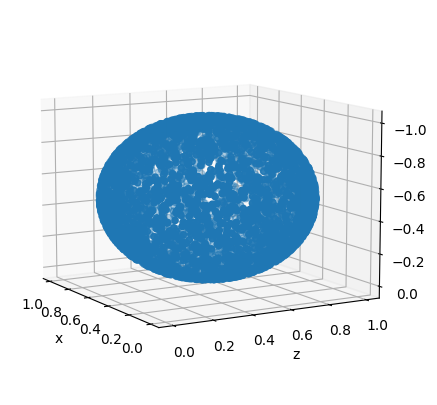

Iteration 2/500, Loss: 0.099455
Iteration 3/500, Loss: 0.093683
Iteration 4/500, Loss: 0.088980
Iteration 5/500, Loss: 0.087857
Iteration 6/500, Loss: 0.086370
Iteration 7/500, Loss: 0.083126
Iteration 8/500, Loss: 0.081712
Iteration 9/500, Loss: 0.076765
Iteration 10/500, Loss: 0.076800
Iteration 11/500, Loss: 0.073226
Iteration 12/500, Loss: 0.071148
Iteration 13/500, Loss: 0.069703
Iteration 14/500, Loss: 0.067932
Iteration 15/500, Loss: 0.064877
Iteration 16/500, Loss: 0.063813
Iteration 17/500, Loss: 0.060995
Iteration 18/500, Loss: 0.059221
Iteration 19/500, Loss: 0.058491
Iteration 20/500, Loss: 0.056082
Iteration 21/500, Loss: 0.054501
Iteration 22/500, Loss: 0.053602
Iteration 23/500, Loss: 0.050565
Iteration 24/500, Loss: 0.049339
Iteration 25/500, Loss: 0.048035
Iteration 26/500, Loss: 0.046214
Iteration 27/500, Loss: 0.044937
Iteration 28/500, Loss: 0.043559
Iteration 29/500, Loss: 0.041548
Iteration 30/500, Loss: 0.039764
Iteration 31/500, Loss: 0.038806
Iteration 32/500, 

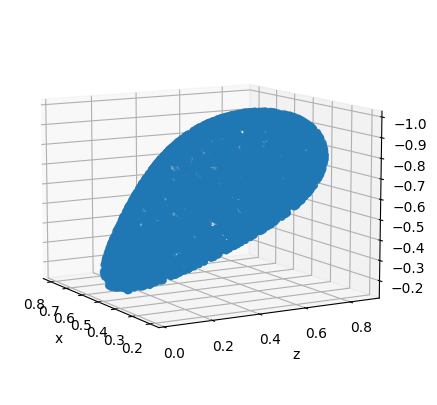

Iteration 102/500, Loss: 0.006955
Iteration 103/500, Loss: 0.006941
Iteration 104/500, Loss: 0.006885
Iteration 105/500, Loss: 0.006815
Iteration 106/500, Loss: 0.006711
Iteration 107/500, Loss: 0.006679
Iteration 108/500, Loss: 0.006637
Iteration 109/500, Loss: 0.006595
Iteration 110/500, Loss: 0.006602
Iteration 111/500, Loss: 0.006588
Iteration 112/500, Loss: 0.006516
Iteration 113/500, Loss: 0.006505
Iteration 114/500, Loss: 0.006483
Iteration 115/500, Loss: 0.006504
Iteration 116/500, Loss: 0.006437
Iteration 117/500, Loss: 0.006267
Iteration 118/500, Loss: 0.006245
Iteration 119/500, Loss: 0.006187
Iteration 120/500, Loss: 0.006223
Iteration 121/500, Loss: 0.006155
Iteration 122/500, Loss: 0.006190
Iteration 123/500, Loss: 0.006148
Iteration 124/500, Loss: 0.006116
Iteration 125/500, Loss: 0.006043
Iteration 126/500, Loss: 0.006047
Iteration 127/500, Loss: 0.006009
Iteration 128/500, Loss: 0.006030
Iteration 129/500, Loss: 0.005933
Iteration 130/500, Loss: 0.006024
Iteration 131/

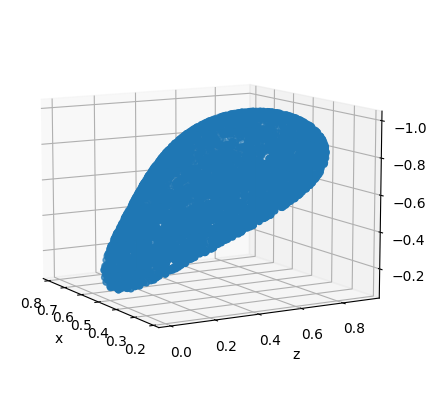

Iteration 202/500, Loss: 0.004915
Iteration 203/500, Loss: 0.004921
Iteration 204/500, Loss: 0.004893
Iteration 205/500, Loss: 0.004869
Iteration 206/500, Loss: 0.004876
Iteration 207/500, Loss: 0.004849
Iteration 208/500, Loss: 0.004823
Iteration 209/500, Loss: 0.004824
Iteration 210/500, Loss: 0.004905
Iteration 211/500, Loss: 0.004781
Iteration 212/500, Loss: 0.004834
Iteration 213/500, Loss: 0.004838
Iteration 214/500, Loss: 0.004783
Iteration 215/500, Loss: 0.004785
Iteration 216/500, Loss: 0.004798
Iteration 217/500, Loss: 0.004795
Iteration 218/500, Loss: 0.004804
Iteration 219/500, Loss: 0.004809
Iteration 220/500, Loss: 0.004756
Iteration 221/500, Loss: 0.004720
Iteration 222/500, Loss: 0.004725
Iteration 223/500, Loss: 0.004752
Iteration 224/500, Loss: 0.004793
Iteration 225/500, Loss: 0.004721
Iteration 226/500, Loss: 0.004635
Iteration 227/500, Loss: 0.004819
Iteration 228/500, Loss: 0.004760
Iteration 229/500, Loss: 0.004679
Iteration 230/500, Loss: 0.004694
Iteration 231/

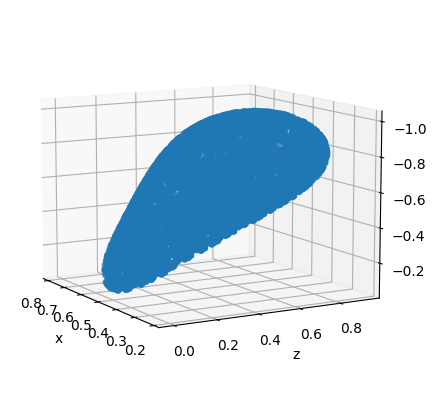

Iteration 302/500, Loss: 0.004400
Iteration 303/500, Loss: 0.004433
Iteration 304/500, Loss: 0.004368
Iteration 305/500, Loss: 0.004445
Iteration 306/500, Loss: 0.004452
Iteration 307/500, Loss: 0.004431
Iteration 308/500, Loss: 0.004432
Iteration 309/500, Loss: 0.004493
Iteration 310/500, Loss: 0.004410
Iteration 311/500, Loss: 0.004355
Iteration 312/500, Loss: 0.004381
Iteration 313/500, Loss: 0.004381
Iteration 314/500, Loss: 0.004380
Iteration 315/500, Loss: 0.004397
Iteration 316/500, Loss: 0.004448
Iteration 317/500, Loss: 0.004386
Iteration 318/500, Loss: 0.004365
Iteration 319/500, Loss: 0.004388
Iteration 320/500, Loss: 0.004334
Iteration 321/500, Loss: 0.004304
Iteration 322/500, Loss: 0.004421
Iteration 323/500, Loss: 0.004379
Iteration 324/500, Loss: 0.004348
Iteration 325/500, Loss: 0.004340
Iteration 326/500, Loss: 0.004357
Iteration 327/500, Loss: 0.004352
Iteration 328/500, Loss: 0.004317
Iteration 329/500, Loss: 0.004362
Iteration 330/500, Loss: 0.004290
Iteration 331/

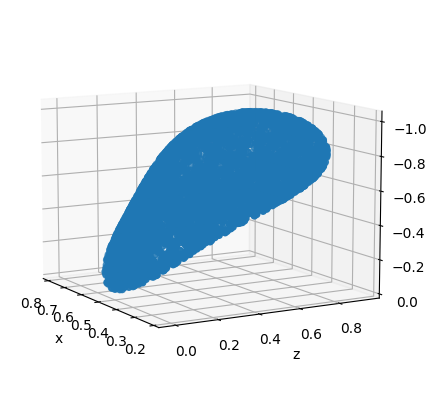

Iteration 402/500, Loss: 0.004260
Iteration 403/500, Loss: 0.004225
Iteration 404/500, Loss: 0.004197
Iteration 405/500, Loss: 0.004217
Iteration 406/500, Loss: 0.004212
Iteration 407/500, Loss: 0.004207
Iteration 408/500, Loss: 0.004204
Iteration 409/500, Loss: 0.004204
Iteration 410/500, Loss: 0.004191
Iteration 411/500, Loss: 0.004243
Iteration 412/500, Loss: 0.004148
Iteration 413/500, Loss: 0.004215
Iteration 414/500, Loss: 0.004237
Iteration 415/500, Loss: 0.004225
Iteration 416/500, Loss: 0.004220
Iteration 417/500, Loss: 0.004242
Iteration 418/500, Loss: 0.004195
Iteration 419/500, Loss: 0.004204
Iteration 420/500, Loss: 0.004210
Iteration 421/500, Loss: 0.004244
Iteration 422/500, Loss: 0.004222
Iteration 423/500, Loss: 0.004168
Iteration 424/500, Loss: 0.004182
Iteration 425/500, Loss: 0.004214
Iteration 426/500, Loss: 0.004182
Iteration 427/500, Loss: 0.004207
Iteration 428/500, Loss: 0.004162
Iteration 429/500, Loss: 0.004193
Iteration 430/500, Loss: 0.004165
Iteration 431/

In [42]:
settings = {
    'num_layers' : 3,
    'dimension' : (3,3,3), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 500
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_03.pkl' , data)

Iteration 1/100, Loss: 0.100406


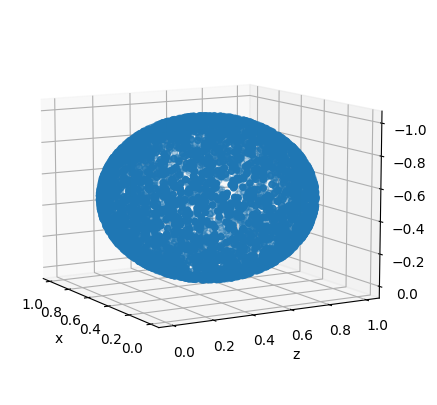

Iteration 2/100, Loss: 0.098974
Iteration 3/100, Loss: 0.097046
Iteration 4/100, Loss: 0.096728
Iteration 5/100, Loss: 0.097425
Iteration 6/100, Loss: 0.096189
Iteration 7/100, Loss: 0.093409
Iteration 8/100, Loss: 0.093000
Iteration 9/100, Loss: 0.092996
Iteration 10/100, Loss: 0.092638
Iteration 11/100, Loss: 0.091560
Iteration 12/100, Loss: 0.088623
Iteration 13/100, Loss: 0.089928
Iteration 14/100, Loss: 0.089477
Iteration 15/100, Loss: 0.087654
Iteration 16/100, Loss: 0.086151
Iteration 17/100, Loss: 0.086584
Iteration 18/100, Loss: 0.084094
Iteration 19/100, Loss: 0.084403
Iteration 20/100, Loss: 0.082720
Iteration 21/100, Loss: 0.082522
Iteration 22/100, Loss: 0.079754
Iteration 23/100, Loss: 0.080506
Iteration 24/100, Loss: 0.079532
Iteration 25/100, Loss: 0.078433
Iteration 26/100, Loss: 0.078345
Iteration 27/100, Loss: 0.077799
Iteration 28/100, Loss: 0.077020
Iteration 29/100, Loss: 0.074717
Iteration 30/100, Loss: 0.075303
Iteration 31/100, Loss: 0.073619
Iteration 32/100, 

In [43]:
settings = {
    'num_layers' : 3,
    'dimension' : (5,5,5), 
    'learning_rate' : 0.5,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 100
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_04.pkl' , data)

Iteration 1/100, Loss: 0.101517


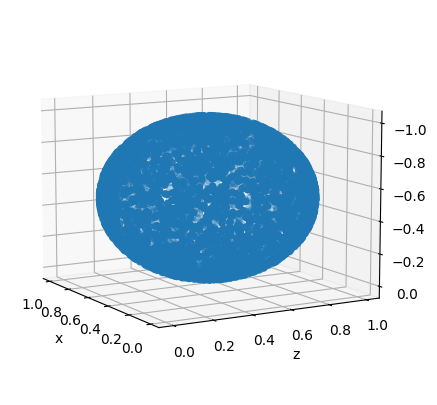

Iteration 2/100, Loss: 0.101532
Iteration 3/100, Loss: 0.098640
Iteration 4/100, Loss: 0.099208
Iteration 5/100, Loss: 0.099719
Iteration 6/100, Loss: 0.101082
Iteration 7/100, Loss: 0.100148
Iteration 8/100, Loss: 0.097491
Iteration 9/100, Loss: 0.099621
Iteration 10/100, Loss: 0.098567
Iteration 11/100, Loss: 0.099148
Iteration 12/100, Loss: 0.097849
Iteration 13/100, Loss: 0.098021
Iteration 14/100, Loss: 0.098207
Iteration 15/100, Loss: 0.096923
Iteration 16/100, Loss: 0.096707
Iteration 17/100, Loss: 0.095192
Iteration 18/100, Loss: 0.097223
Iteration 19/100, Loss: 0.095771
Iteration 20/100, Loss: 0.097715
Iteration 21/100, Loss: 0.095604
Iteration 22/100, Loss: 0.095333
Iteration 23/100, Loss: 0.096886
Iteration 24/100, Loss: 0.095887
Iteration 25/100, Loss: 0.095441
Iteration 26/100, Loss: 0.096597
Iteration 27/100, Loss: 0.095787
Iteration 28/100, Loss: 0.095512
Iteration 29/100, Loss: 0.095086
Iteration 30/100, Loss: 0.095424
Iteration 31/100, Loss: 0.093944
Iteration 32/100, 

In [44]:
settings = {
    'num_layers' : 3,
    'dimension' : (5,5,5), 
    'learning_rate' : 0.1,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 1.0,
    'w_normal' : 0.01,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 100
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_05.pkl' , data)

Iteration 1/100, Loss: 0.099051


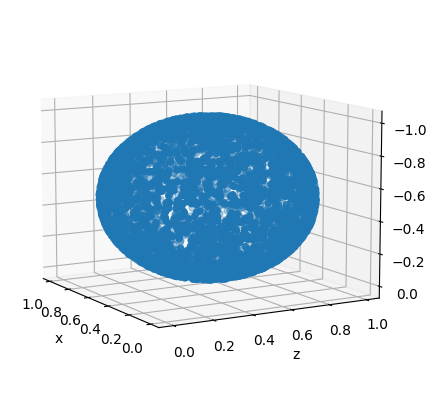

Iteration 2/100, Loss: 0.098079
Iteration 3/100, Loss: 0.099329
Iteration 4/100, Loss: 0.101763
Iteration 5/100, Loss: 0.097085
Iteration 6/100, Loss: 0.097911
Iteration 7/100, Loss: 0.097385
Iteration 8/100, Loss: 0.099215
Iteration 9/100, Loss: 0.099299
Iteration 10/100, Loss: 0.098624
Iteration 11/100, Loss: 0.097950
Iteration 12/100, Loss: 0.099312
Iteration 13/100, Loss: 0.098203
Iteration 14/100, Loss: 0.098572
Iteration 15/100, Loss: 0.096407
Iteration 16/100, Loss: 0.096438
Iteration 17/100, Loss: 0.097502
Iteration 18/100, Loss: 0.096477
Iteration 19/100, Loss: 0.097224
Iteration 20/100, Loss: 0.097807
Iteration 21/100, Loss: 0.097181
Iteration 22/100, Loss: 0.095369
Iteration 23/100, Loss: 0.094908
Iteration 24/100, Loss: 0.095658
Iteration 25/100, Loss: 0.094489
Iteration 26/100, Loss: 0.095823
Iteration 27/100, Loss: 0.094973
Iteration 28/100, Loss: 0.094493
Iteration 29/100, Loss: 0.093799
Iteration 30/100, Loss: 0.094324
Iteration 31/100, Loss: 0.094818
Iteration 32/100, 

In [ ]:
settings = {
    'num_layers' : 3,
    'dimension' : (5,5,5), 
    'learning_rate' : 0.1,
    # Loss weights
    'w_chamfer' : 1.0,
    'w_edge' : 0.5,
    'w_normal' : 0.1,
    'w_laplacian' : 0.1,
    'print_interval' : 100,
    'num_iterations' : 100
}

result = train(src_mesh, trg_mesh,**settings)

final_mesh = result["final_mesh"]
deltas = result["delta_points"]
err_list = result["error_hist"]

data = {'params':settings, 'final_mesh' : final_mesh, 'deltas' : deltas, 'err_list' : err_list}
save_training_data('./treino_06.pkl' , data)

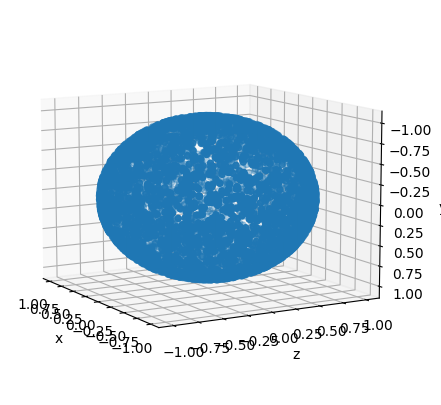

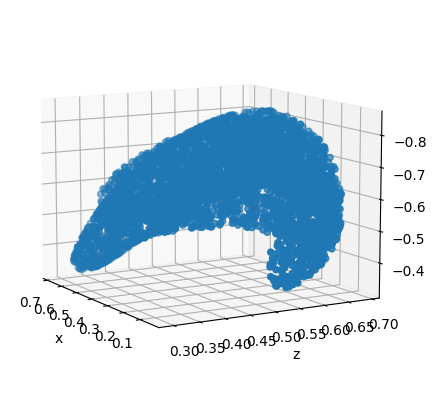

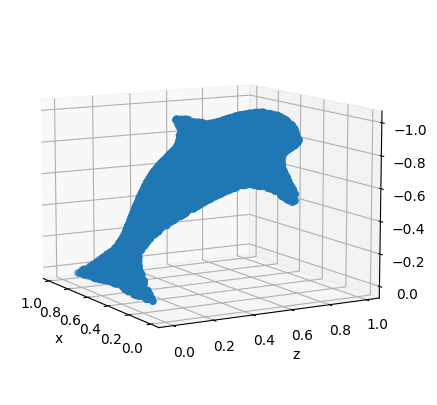

In [58]:
plot_pointcloud(src_mesh)
plot_pointcloud(new_src_mesh_ffd)
plot_pointcloud(trg_mesh)

## Versão 3 com Clipping de Grad

In [43]:
from pytorch3d.loss import chamfer_distance, mesh_edge_loss, mesh_normal_consistency, mesh_laplacian_smoothing
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj
from pytorch3d.ops import sample_points_from_meshes
import torch
import torch.nn.utils

# Carrega a malha alvo
trg_obj = 'dolphin.obj'
trg_verts, trg_faces, _ = load_obj(trg_obj)
min_vals = trg_verts.min(dim=0, keepdim=True)[0]
max_vals = trg_verts.max(dim=0, keepdim=True)[0]
trg_verts = (trg_verts - min_vals) / (max_vals - min_vals)

mesh = Meshes(verts=[trg_verts], faces=[trg_faces.verts_idx])

src_mesh = ico_sphere(4, device)
src_verts = src_mesh.get_mesh_verts_faces(0)[0]
min_vals = src_verts.min(dim=0, keepdim=True)[0]
max_vals = src_verts.max(dim=0, keepdim=True)[0]
src_verts = (src_verts - min_vals) / (max_vals - min_vals)


# Configura os parâmetros de FFD e a malha de controle
l, m, n = 3, 3, 3
# control_points = torch.rand((l, m, n, 3), requires_grad=False)
control_points_delta = torch.zeros((l, m, n, 3), requires_grad=True)  # Deltas ajustáveis para FFD


# Configura a camada FFD
ffd_layer = FFDLayer(l=l, m=m, n=n)

# Configura o otimizador com uma taxa de aprendizado menor
learning_rate = 0.1
optimizer = torch.optim.SGD([control_points_delta], lr=learning_rate)

# Pesos das perdas
w_chamfer = 1.0 
w_edge = 1.0 
w_normal = 0.01 
w_laplacian = 0.1 

# Iterações de treinamento
num_iterations = 50
sample_trg = sample_points_from_meshes(trg_mesh, 5000)

for i in range(num_iterations):
    optimizer.zero_grad()  # Zera os gradientes do otimizador
    
    # Aplica FFD nos vértices da malha inicial
    deformed_verts = ffd_layer(src_verts, control_points_delta)
    
    # Cria a nova malha deformada
    new_src_mesh_ffd = Meshes(verts=[deformed_verts], faces=[src_mesh.faces_packed()])
    
    # Amostra pontos da superfície de ambas as malhas para cálculo da Chamfer Loss
    sample_src_ffd = sample_points_from_meshes(new_src_mesh_ffd, 5000)
    
    # Calcula as perdas
    loss_chamfer_ffd, _ = chamfer_distance(sample_trg, sample_src_ffd)
    loss_edge_ffd = mesh_edge_loss(new_src_mesh_ffd)
    loss_normal_ffd = mesh_normal_consistency(new_src_mesh_ffd)
    loss_laplacian_ffd = mesh_laplacian_smoothing(new_src_mesh_ffd, method="uniform")
    
    # Soma ponderada das perdas
    loss_ffd = (loss_chamfer_ffd * w_chamfer +
                loss_edge_ffd * w_edge +
                loss_normal_ffd * w_normal +
                loss_laplacian_ffd * w_laplacian)
    
    # Imprime a perda total para monitoramento
    print(f'Iteração {i + 1}/{num_iterations}, Loss: {loss_ffd.item():.6f}')
    
    # Backpropagation
    loss_ffd.backward()

    # Verifica se há gradientes NaN
    if torch.isnan(control_points_delta.grad).any():
        print("Warning: Gradientes NaN detectados em control_points_delta.grad!")
        break

    # # Aplica o clipping de gradiente para evitar instabilidade
    # torch.nn.utils.clip_grad_norm_([control_points_delta], max_norm=1.0)
    
    # Atualiza os deltas dos pontos de controle com o otimizador
    optimizer.step()
    
    # Verifica se control_points_delta contém valores NaN após a atualização
    if torch.isnan(control_points_delta).any():
        print("Warning: Valores NaN detectados em control_points_delta!")
        break


/usr/local/lib/python3.8/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


RuntimeError: The size of tensor a (27) must match the size of tensor b (3) at non-singleton dimension 2

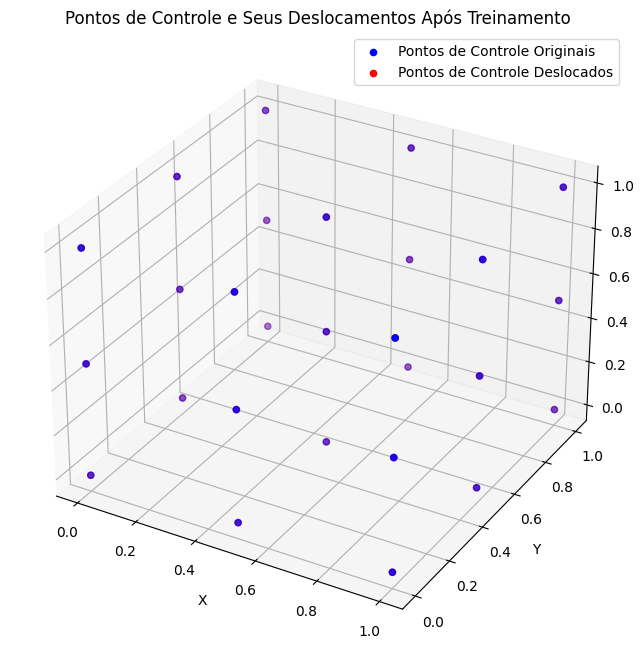

In [125]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_control_points(control_points, control_points_delta):
    """
    Plota os pontos de controle antes e depois dos deslocamentos, conectando-os com linhas.
    """
    # Calcula os pontos de controle deslocados
    deformed_control_points = control_points + control_points_delta

    # Cria um gráfico 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Extrai os pontos originais e deslocados em listas separadas para facilitar o plot
    original_x, original_y, original_z = control_points[..., 0].flatten(), control_points[..., 1].flatten(), control_points[..., 2].flatten()
    deformed_x, deformed_y, deformed_z = deformed_control_points[..., 0].flatten(), deformed_control_points[..., 1].flatten(), deformed_control_points[..., 2].flatten()

    # Plotando os pontos de controle originais
    ax.scatter(original_x, original_y, original_z, color='blue', label='Pontos de Controle Originais')
    
    # Plotando os pontos de controle deslocados
    ax.scatter(deformed_x, deformed_y, deformed_z, color='red', label='Pontos de Controle Deslocados')

    # Conectando cada ponto de controle original ao seu ponto deslocado com linhas verdes
    for i in range(len(original_x)):
        ax.plot([original_x[i], deformed_x[i]], 
                [original_y[i], deformed_y[i]], 
                [original_z[i], deformed_z[i]], 
                color='green', linestyle='--', linewidth=1)

    # Ajustes no gráfico
    ax.set_title("Pontos de Controle e Seus Deslocamentos Após Treinamento")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    
    plt.show()

# Plotando após o treinamento
plot_control_points(torch.tensor([[[[i/(l-1), j/(m-1), k/(n-1)] for k in range(n)] for j in range(m)] for i in range(l)]).detach().numpy(), control_points_delta.detach().numpy())


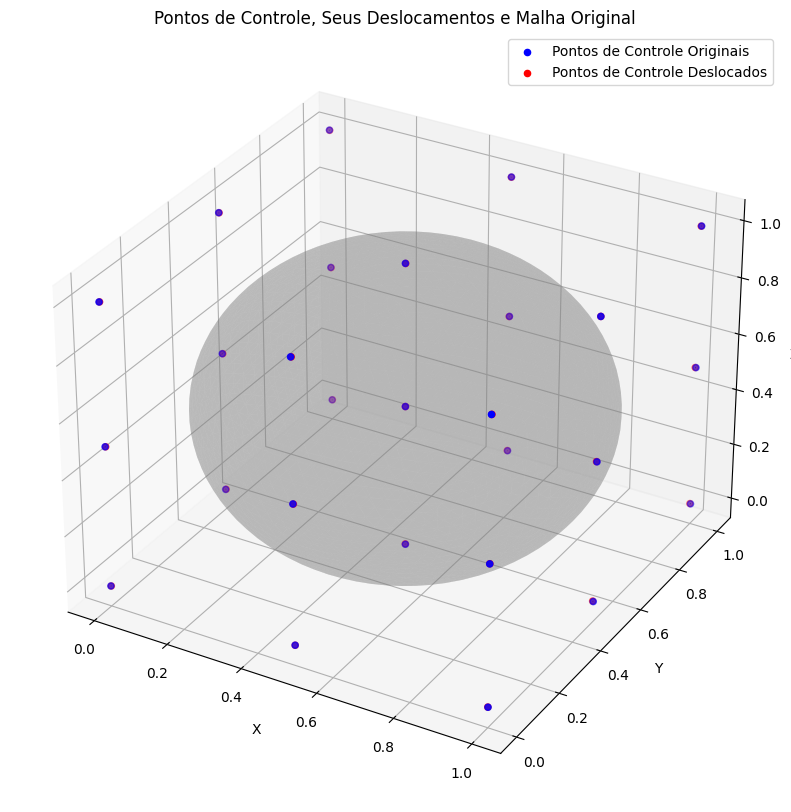

In [130]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

def plot_control_points_with_mesh(control_points, control_points_delta, verts, faces):
    """
    Plota os pontos de controle antes e depois dos deslocamentos, conectando-os com linhas,
    e adiciona a malha original com transparência.
    """
    # Calcula os pontos de controle deslocados
    deformed_control_points = control_points + control_points_delta

    # Cria um gráfico 3D
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extrai os pontos originais e deslocados em listas separadas para facilitar o plot
    original_x, original_y, original_z = control_points[..., 0].flatten(), control_points[..., 1].flatten(), control_points[..., 2].flatten()
    deformed_x, deformed_y, deformed_z = deformed_control_points[..., 0].flatten(), deformed_control_points[..., 1].flatten(), deformed_control_points[..., 2].flatten()

    # Plotando os pontos de controle originais
    ax.scatter(original_x, original_y, original_z, color='blue', label='Pontos de Controle Originais')
    
    # Plotando os pontos de controle deslocados
    ax.scatter(deformed_x, deformed_y, deformed_z, color='red', label='Pontos de Controle Deslocados')

    # Conectando cada ponto de controle original ao seu ponto deslocado com linhas verdes
    for i in range(len(original_x)):
        ax.plot([original_x[i], deformed_x[i]], 
                [original_y[i], deformed_y[i]], 
                [original_z[i], deformed_z[i]], 
                color='green', linestyle='--', linewidth=1)

    # Plotando a malha original com transparência
    verts_np = verts.detach().cpu().numpy()  # Convertendo os vértices para numpy
    faces_np = faces.detach().cpu().numpy()  # Convertendo as faces para numpy

    mesh_poly = Poly3DCollection(verts_np[faces_np], alpha=0.3, facecolor='gray', edgecolor='none')
    ax.add_collection3d(mesh_poly)

    # Ajustes no gráfico
    ax.set_title("Pontos de Controle, Seus Deslocamentos e Malha Original")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    
    plt.show()

# Exemplo de chamada para plotar com a malha original
plot_control_points_with_mesh(torch.tensor([[[[i/(l-1), j/(m-1), k/(n-1)] for k in range(n)] for j in range(m)] for i in range(l)]).detach().numpy(), control_points_delta.detach().numpy(), src_verts, faces.verts_idx)


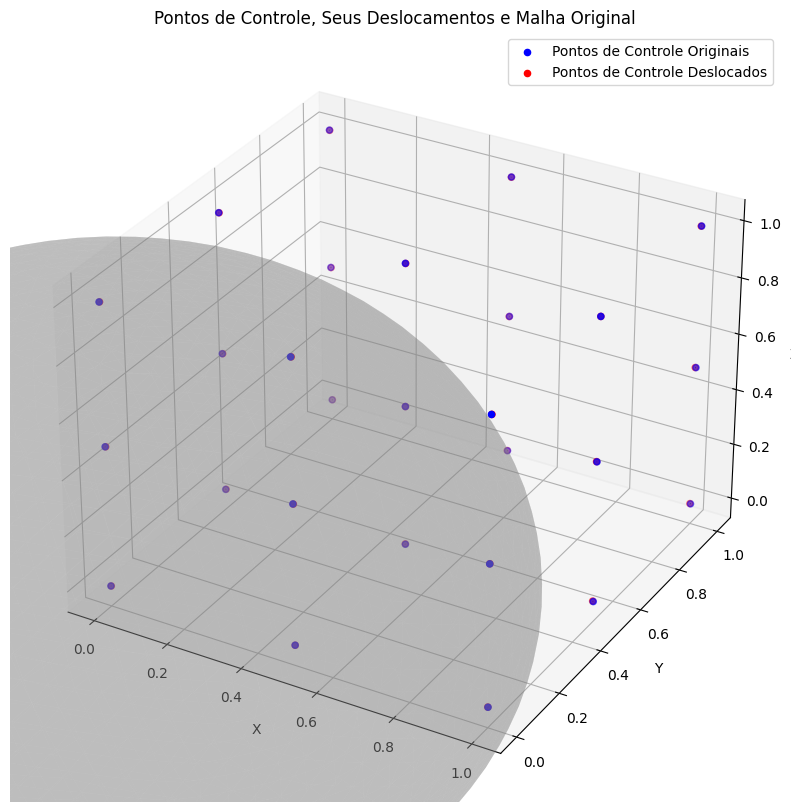

In [133]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

def plot_control_points_with_mesh(control_points, control_points_delta, mesh):
    """
    Plota os pontos de controle antes e depois dos deslocamentos, conectando-os com linhas,
    e adiciona a malha original com transparência.
    
    Args:
        control_points: tensor com os pontos de controle originais (l, m, n, 3).
        control_points_delta: tensor com os deslocamentos dos pontos de controle (l, m, n, 3).
        mesh: instância de Meshes do pytorch3d representando a malha original.
    """
    # Calcula os pontos de controle deslocados
    deformed_control_points = control_points + control_points_delta

    # Cria um gráfico 3D
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extrai os pontos originais e deslocados em listas separadas para facilitar o plot
    original_x, original_y, original_z = control_points[..., 0].flatten(), control_points[..., 1].flatten(), control_points[..., 2].flatten()
    deformed_x, deformed_y, deformed_z = deformed_control_points[..., 0].flatten(), deformed_control_points[..., 1].flatten(), deformed_control_points[..., 2].flatten()

    # Plotando os pontos de controle originais
    ax.scatter(original_x, original_y, original_z, color='blue', label='Pontos de Controle Originais')
    
    # Plotando os pontos de controle deslocados
    ax.scatter(deformed_x, deformed_y, deformed_z, color='red', label='Pontos de Controle Deslocados')

    # Conectando cada ponto de controle original ao seu ponto deslocado com linhas verdes
    for i in range(len(original_x)):
        ax.plot([original_x[i], deformed_x[i]], 
                [original_y[i], deformed_y[i]], 
                [original_z[i], deformed_z[i]], 
                color='green', linestyle='--', linewidth=1)

    # Plotando a malha original com transparência
    verts_np = mesh.verts_packed().detach().cpu().numpy()  # Vértices da malha convertidos para numpy
    faces_np = mesh.faces_packed().detach().cpu().numpy()  # Faces da malha convertidas para numpy

    mesh_poly = Poly3DCollection(verts_np[faces_np], alpha=0.3, facecolor='gray', edgecolor='none')
    ax.add_collection3d(mesh_poly)

    # Ajustes no gráfico
    ax.set_title("Pontos de Controle, Seus Deslocamentos e Malha Original")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    
    plt.show()

# Exemplo de chamada para plotar com a malha original
plot_control_points_with_mesh(torch.tensor([[[[i/(l-1), j/(m-1), k/(n-1)] for k in range(n)] for j in range(m)] for i in range(l)]).detach().numpy(), control_points_delta.detach().numpy(), src_mesh)
